## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import torch

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_valid, y_valid = train_test_split(train_df, train_df["target"],test_size=0.2,random_state =123)
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

# 1. Original tutorial

## 1.1 A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [3]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [4]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


## 1.2 Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [6]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [7]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


The above tells us that:
1. There are 54 unique words (or "tokens") in the first five tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Now let's create vectors for all of our tweets.

In [8]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

In [9]:
train_vectors

<7613x21637 sparse matrix of type '<class 'numpy.int64'>'
	with 111497 stored elements in Compressed Sparse Row format>

In [10]:
test_vectors

<3263x21637 sparse matrix of type '<class 'numpy.int64'>'
	with 41511 stored elements in Compressed Sparse Row format>

## 1.3 UMAP

In [14]:
import umap  # pip install umap-learn

# Create the mapper
mapper = umap.UMAP()
# Fit to the data
reducer = mapper.fit_transform(train_vectors, train_df["target"])

Text(0.5, 1.0, 'UMAP projection')

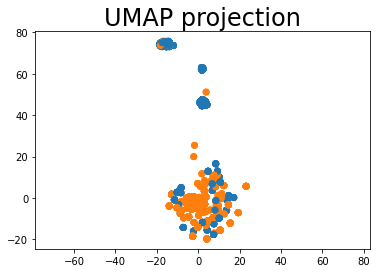

In [20]:
plt.scatter(
    reducer[:, 0],
    reducer[:, 1],
    c=[sns.color_palette()[x] for x in train_df["target"]])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

## 1.4 lazypredict

In [11]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

/data/software/Anaconda3/4.4.0-foss-2017a/envs/nlp/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [54]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, classifiers=classifiers_select)

X_train, X_test, y_train, y_test = train_test_split(train_df, train_df["target"],test_size=0.3,random_state =123)
X_train = count_vectorizer.transform(X_train["text"]).todense()
X_test = count_vectorizer.transform(X_test["text"]).todense()
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 24/24 [57:15<00:00, 143.15s/it]  

         Accuracy  Balanced Accuracy  ROC AUC  F1 Score  Time Taken
Model                                                              
ABCMeta      0.81               0.79     0.79      0.81       11.06
type         0.80               0.79     0.79      0.80      183.49
type         0.80               0.78     0.78      0.80       13.11
ABCMeta      0.80               0.78     0.78      0.80      177.53
type         0.80               0.78     0.78      0.79       64.55
ABCMeta      0.77               0.76     0.76      0.77       12.94
type         0.77               0.76     0.76      0.77       29.99
ABCMeta      0.78               0.75     0.75      0.77       95.17
ABCMeta      0.76               0.75     0.75      0.76       15.33
ABCMeta      0.77               0.74     0.74      0.76     1342.41
type         0.76               0.74     0.74      0.75      373.80
ABCMeta      0.76               0.74     0.74      0.75       96.81
ABCMeta      0.75               0.73     0.73   

In [56]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ABCMeta,0.81,0.79,0.79,0.81,11.06
type,0.80,0.79,0.79,0.80,183.49
type,0.80,0.78,0.78,0.80,13.11
ABCMeta,0.80,0.78,0.78,0.80,177.53
type,0.80,0.78,0.78,0.79,64.55
ABCMeta,0.77,0.76,0.76,0.77,12.94
type,0.77,0.76,0.76,0.77,29.99
ABCMeta,0.78,0.75,0.75,0.77,95.17
ABCMeta,0.76,0.75,0.75,0.76,15.33


## 1.5 Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [13]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1, so let's use that here.

In [14]:
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.59421842, 0.5642787 , 0.64149093])

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [15]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier()

In [16]:
sample_submission = pd.read_csv("./sample_submission.csv")

In [17]:
sample_submission["target"] = clf.predict(test_vectors)

In [18]:
sample_submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1


In [19]:
sample_submission.to_csv("submission.csv", index=False)

Now, in the viewer, you can submit the above file to the competition! Good luck!

# 2. GloVe
https://amarsaini.github.io/Epoching-Blog/jupyter/nlp/pytorch/fastai/huggingface/2021/06/27/NLP-from-Scratch-with-PyTorch-FastAI-and-HuggingFace.html

In [28]:
from fastai.text.all import *
import pandas as pd
import torch
import torchtext
from torchtext.data import get_tokenizer

In [29]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [30]:
tokenizer = get_tokenizer("basic_english")

In [31]:
tokens = L(tokenizer(train_df.loc[0, 'text']))
tokens

(#13) ['our','deeds','are','the','reason','of','this','#earthquake','may','allah'...]

In [32]:
from collections import Counter

token_counter = Counter()

for sample_text in train_df['text']:
    tokens = tokenizer(sample_text)
    token_counter.update(tokens)

token_counter.most_common(n=25)

[('.', 11696),
 ('//t', 4718),
 ('http', 4309),
 ('the', 3266),
 ("'", 3157),
 ('?', 3126),
 ('a', 2183),
 ('in', 1973),
 ('to', 1944),
 ('of', 1822),
 ('i', 1740),
 ('and', 1420),
 ('!', 1173),
 ('is', 948),
 ('s', 895),
 ('for', 891),
 ('you', 888),
 ('on', 852),
 ('-', 782),
 ('it', 765),
 ('my', 677),
 ('that', 618),
 ('with', 570),
 ('at', 538),
 ('by', 519)]

In [33]:
sorted_counter = dict(token_counter.most_common())

# Create vocab containing tokens with a minimum frequency of 20
my_vocab = torchtext.vocab.vocab(sorted_counter, min_freq=20)

# Add the unknown token, and use this by default for unknown words
unk_token = '<unk>'
my_vocab.insert_token(unk_token, 0)
my_vocab.set_default_index(0)

# Add the pad token
pad_token = '<pad>'
my_vocab.insert_token(pad_token, 1)

# Show vocab size, and examples of tokens
len(my_vocab.get_itos()), my_vocab.get_itos()[:25]

(875,
 ['<unk>',
  '<pad>',
  '.',
  '//t',
  'http',
  'the',
  "'",
  '?',
  'a',
  'in',
  'to',
  'of',
  'i',
  'and',
  '!',
  'is',
  's',
  'for',
  'you',
  'on',
  '-',
  'it',
  'my',
  'that',
  'with'])

In [34]:
glove = torchtext.vocab.GloVe(name = '6B', dim = 100)
glove.vectors.shape

torch.Size([400000, 100])

In [35]:
my_vocab.vectors = glove.get_vecs_by_tokens(my_vocab.get_itos())
my_vocab.vectors.shape

torch.Size([875, 100])

In [36]:
tot_transferred = 0
for v in my_vocab.vectors:
    if not v.equal(torch.zeros(100)):
        tot_transferred += 1
        
tot_transferred, len(my_vocab)

(853, 875)

In [37]:
for i in range(my_vocab.vectors.shape[0]):
    if my_vocab.vectors[i].equal(torch.zeros(100)):
        my_vocab.vectors[i] = torch.randn(100)

In [38]:
sample_text = train_df['text'][0]
tokens = L(tokenizer(sample_text))
numericalized_tokens = [my_vocab[token] for token in tokens]
numericalized_tokens = torch.tensor(numericalized_tokens)
' '.join([my_vocab.get_itos()[num] for num in numericalized_tokens])

'our <unk> are the reason of this <unk> may <unk> <unk> us all'

In [39]:
max_tokens = 128
numericalized_tokens = [my_vocab[token] for token in tokens]

if len(numericalized_tokens) < max_tokens:
    numericalized_tokens += [1] * (max_tokens-len(numericalized_tokens))
else:
    numericalized_tokens = numericalized_tokens[:max_tokens]

numericalized_tokens = torch.tensor(numericalized_tokens)
numericalized_tokens

tensor([121,   0,  31,   5, 837,  11,  27,   0, 138,   0,   0, 100,  50,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1])

In [40]:
from torch import nn

class Simple_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab, max_tokens):
        self.df = df
        self.vocab = vocab
        self.max_length = max_tokens
        self.tokenizer = get_tokenizer("basic_english")
        
        # label 1 is negative sentiment and label 2 is positive sentiment
        self.label_map = {1:1, 0:0}
        
    def __len__(self):
        return len(self.df)

    def decode(self, numericalized_tokens):
        return ' '.join([self.vocab.get_itos()[num] for num in numericalized_tokens])

    def __getitem__(self, index):
        text, label = self.df.loc[index, ['text', 'target']]
        label = self.label_map[label]
        label = torch.tensor(label)

        tokens = tokenizer(text)
        numericalized_tokens = [my_vocab[token] for token in tokens]

        if len(numericalized_tokens) < max_tokens:
            numericalized_tokens += [1] * (max_tokens-len(numericalized_tokens))
        else:
            numericalized_tokens = numericalized_tokens[:max_tokens]

        numericalized_tokens = torch.tensor(numericalized_tokens)
        
        return numericalized_tokens, label

In [41]:
train_dataset = Simple_Dataset(X_train, vocab=my_vocab, max_tokens=128)
valid_dataset = Simple_Dataset(X_valid, vocab=my_vocab, max_tokens=128)
len(train_dataset), len(valid_dataset)

(6090, 1523)

In [42]:
train_dl = DataLoader(train_dataset, bs=32, shuffle=True)
valid_dl = DataLoader(valid_dataset, bs=32)

dls = DataLoaders(train_dl, valid_dl)

In [43]:
class Model(nn.Module):
  
    def __init__(self, vocab, num_classes):
        super().__init__()
        
        vocab_size, emb_size = vocab.vectors.shape
        self.emb = nn.Embedding(vocab_size, emb_size, _weight=vocab.vectors)
        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = 64, batch_first = True, num_layers = 2)
        
        self.head = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, num_classes))
        
    def forward(self, batch_data):

        token_embs = self.emb(batch_data)
        
        outputs, (h_n, c_n) = self.lstm(token_embs)
        
        # Assuming a batch size of 32, h_n will have a shape of:
        
        # shape = 2, 32, 64
        last_hidden_state = h_n
        # shape = 32, 2, 64
        last_hidden_state = last_hidden_state.permute(1,0,2)
        # shape = 32, 128
        last_hidden_state = last_hidden_state.flatten(start_dim=1)

        logits = self.head(last_hidden_state)
        
        return logits

In [44]:
model = Model(my_vocab, num_classes=2)
model

Model(
  (emb): Embedding(875, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [45]:
batched_data, batched_labels = train_dl.one_batch()
print(batched_data.shape, batched_labels.shape)

torch.Size([32, 128]) torch.Size([32])


In [46]:
with torch.no_grad():
    logits = model(batched_data)
logits.shape

torch.Size([32, 2])

In [47]:
loss_func = nn.CrossEntropyLoss()

loss = loss_func(logits, batched_labels)
loss

tensor(0.6969)

In [48]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=[accuracy])
learn

SuggestedLRs(valley=0.00015848931798245758)

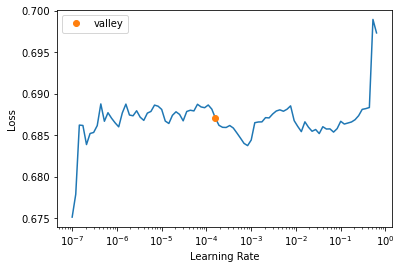

In [53]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(5, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.685195,0.681543,0.577150,00:11
1,0.681069,0.682012,0.577150,00:11
2,0.685550,0.681947,0.577150,00:11
3,0.681300,0.681235,0.577150,00:11
4,0.684673,0.681265,0.577150,00:11
